In [12]:
import pandas as pd
from pandas.tseries.offsets import BDay

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as md
from tqdm import trange
import pickle
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

from utils.portfolio_backtests import *
from utils.trading_model import *
from utils.experiment_utils import *
from utils.portfolio_backtests import MeanVariance

from cvx.covariance.ewma import iterated_ewma, _ewma_cov, _ewma_mean
from cvx.covariance.combination import from_sigmas

import datetime
import random

sns.set()
sns.set(font_scale=1.5)

boolUniformlyDistributedDataset = True
percentageOfRemovedDays = 10

In [13]:
# code to make the dataset not uniformly distributed
def removeRandomDays(dailyChangeReturnDataset, D):
    '''
    returnDataset: dataframe of returnDataset
    D: percentage of days to eliminate randomly from the dataset:10 = 10% of the days are eliminated
    '''

    # calculate the size of the dataset(so the lenght of the column)
    datasetSize = len(dailyChangeReturnDataset.index)
    number_of_days_to_eliminate = int(datasetSize * D / 100)

    # Define the range of indices that can be removed; avoid the first and last days
    valid_indices = list(range(2, datasetSize - 2)) # Randomly select a group of indices to remove

    #Randomly select a group of indices to remove
    indices_to_remove = sorted(random.sample(valid_indices, number_of_days_to_eliminate))
    print("len of indices to remove and interpolate: " + str(len(indices_to_remove)))
    
    # Create a copy of the DataFrame to perform interpolation
    interpolatedReturns = dailyChangeReturnDataset.copy()

    # Interpolate the returns using linear interpolation method
    interpolatedReturns.iloc[indices_to_remove] = np.nan
    interpolatedReturns = interpolatedReturns.interpolate(method='linear', axis=0, limit_area='inside')
    # limit the number of decimals to 6
    interpolatedReturns = interpolatedReturns.round(6)

    # save the interpolated dataset in a csv file
    interpolatedReturns.to_csv("interpolatedReturns.csv")
    
    return interpolatedReturns

# Import Data

In [14]:
stocksPrices = pd.read_csv('data/threeStocksPortfolios.csv', index_col=0, parse_dates=True)
stocksPercentageChangeReturn = pd.read_csv('data/threeStocksPortfolioPercentageChange.csv', index_col=0, parse_dates=True)
uniformlyDistributedReturns = stocksPercentageChangeReturn.copy() # this is a copy of the original dataset returns; i will use this to make it non-uniformly distributed

# Risk-free rate
FF = pd.read_csv('data/ff5.csv', index_col=0, parse_dates=True)
rf_rate = pd.DataFrame(FF.loc[:,"RF"])
rf_rate.index = pd.to_datetime(rf_rate.index, format='%Y%m%d')

# i have 13 years of trading data; 3273 days; now i will split the dataset into 70% training, 20% validation and 10% test

total_days = len(stocksPrices)
date_70_percent = stocksPrices.index[int(total_days * 0.7)]
date_90_percent = stocksPrices.index[int(total_days * 0.9)]

# 70% training
trainingDataWithPrices = stocksPrices.loc[:date_70_percent]
trainingDataWithPercentageChange = stocksPercentageChangeReturn.loc[:date_70_percent]

# Adjust the start date for the validation set to exclude the last date of the training set
validation_start_date = date_70_percent + BDay(1)

# 20% validation
validationDataWithPrices = stocksPrices.loc[validation_start_date:date_90_percent]
validationDataWithPercentageChange = stocksPercentageChangeReturn.loc[validation_start_date:date_90_percent]

# Adjust the start date for the test set to exclude the last date of the validation set
test_start_date = date_90_percent + BDay(1)

# 10% test
testDataWithPrices = stocksPrices.loc[test_start_date:]
testDataWithPercentageChange = stocksPercentageChangeReturn.loc[test_start_date:]

# print the first date and the last date of each dataset
print("First date of training dataset: ", trainingDataWithPrices.index[0])
print("Last date of training dataset: ", trainingDataWithPrices.index[-1])
print("len of training dataset: ", len(trainingDataWithPrices))

print("\nFirst date of validation dataset: ", validationDataWithPrices.index[0])
print("Last date of validation dataset: ", validationDataWithPrices.index[-1])
print("len of validation dataset: ", len(validationDataWithPrices))

print("\nFirst date of test dataset: ", testDataWithPrices.index[0])
print("Last date of test dataset: ", testDataWithPrices.index[-1])
print("len of test dataset: ", len(testDataWithPrices))

print("\ntotal dataset lenght: ", len(stocksPrices))
print("sum of the three datasets: ", len(trainingDataWithPrices) + len(validationDataWithPrices) + len(testDataWithPrices))

First date of training dataset:  2010-01-04 00:00:00
Last date of training dataset:  2019-02-08 00:00:00
len of training dataset:  2291

First date of validation dataset:  2019-02-11 00:00:00
Last date of validation dataset:  2021-09-14 00:00:00
len of validation dataset:  654

First date of test dataset:  2021-09-15 00:00:00
Last date of test dataset:  2022-12-30 00:00:00
len of test dataset:  327

total dataset lenght:  3272
sum of the three datasets:  3272


In [15]:
print("original returns dataframe dimension: " + str(stocksPercentageChangeReturn.shape))

if not boolUniformlyDistributedDataset:

    # if i consider the non-uniformly distributed dataset, i have to apply the linear interpolation to the data to fill the missing values;
    # so i will have not the original dataset with real values, but a dataset with interpolated values
    stocksPercentageChangeReturn = removeRandomDays(uniformlyDistributedReturns, percentageOfRemovedDays) 
    print("returns dataframe dimention after interpolating random days: " + str(stocksPercentageChangeReturn.shape))

    originalDatasetVolatility = uniformlyDistributedReturns.std()
    print("original dataset volatility: " + str(originalDatasetVolatility))

    interterpolatedDatasetVolatility = stocksPercentageChangeReturn.std()
    print("interpolated dataset volatility: " + str(interterpolatedDatasetVolatility))

    # now i have to modify also the training, validation and test datasets; not only the complete dataset because otherwise i will have the full dataset with interpolated values
    # and the training, validation and test datasets with real values

    # 70% training
    trainingDataWithPrices = stocksPrices.loc[:date_70_percent]
    trainingDataWithPercentageChange = stocksPercentageChangeReturn.loc[:date_70_percent]

    # Adjust the start date for the validation set to exclude the last date of the training set
    validation_start_date = date_70_percent + BDay(1)

    # 20% validation
    validationDataWithPrices = stocksPrices.loc[validation_start_date:date_90_percent]
    validationDataWithPercentageChange = stocksPercentageChangeReturn.loc[validation_start_date:date_90_percent]

    # Adjust the start date for the test set to exclude the last date of the validation set
    test_start_date = date_90_percent + BDay(1)

    # 10% test
    testDataWithPrices = stocksPrices.loc[test_start_date:]
    testDataWithPercentageChange = stocksPercentageChangeReturn.loc[test_start_date:]


# Import pickle
with open('data/permco_to_ticker.pkl', 'rb') as f:
    permco_to_ticker = pickle.load(f)

# Create a reverse mapping if necessary
ticker_to_permco = {v: k for k, v in permco_to_ticker.items()}

# Replace ticker symbols with PERMCO codes if the ticker symbol is found in the reverse mapping
columns = [ticker_to_permco.get(col, col) for col in stocksPercentageChangeReturn.columns]
stocksPercentageChangeReturn.columns = columns

# Repeat for uniformlyDistributedReturns
columns_udr = [ticker_to_permco.get(col, col) for col in uniformlyDistributedReturns.columns]
uniformlyDistributedReturns.columns = columns_udr

original returns dataframe dimension: (3272, 3)


# Dictionary Initialization

In [16]:
prescientDict = {}
daily_log_likelihoods = {}
daily_regrets = {}

# collections for plotting charts about the performance of the RW predictor
rwValues = []
rwMeanRegretValues = []
rwMeanlogLikelihoodValues = []
prescientAlreadyPrinted = False

days_greater_than_one_values = []  # To store determinant values where > 1
days_less_than_one_values = []  # To store determinant values where < 1

# Covariance Predictors

PAPER PRESCIENT PREDICTOR IMPLEMENTATION(GROUND TRUTH)

In [17]:
# THIS CODE IS CALCULATING THE REAL VOLATILITY

# prescient is a dictionary that contains the covariance matrix calculated using the ewma formula written inside the paper
# the key of the dictionary is the timestamp and the value is the covariance matrix calculated for that day

# The prescient predictor will always use the original dataset, so it will be uniformly distributed; this is because the prescient predictor is used to compare the other predictors
# and we need to have a measure of the real covariance matrix; so this can't be used with the non-uniformly distributed dataset

for t in uniformlyDistributedReturns.index:
    # get sample covariance matrix for corresponding quarter
    quarter = (t.month-1)//3 + 1  
    cov = np.cov(uniformlyDistributedReturns.loc[(uniformlyDistributedReturns.index.year == t.year) & (uniformlyDistributedReturns.index.quarter == quarter)].values, rowvar=False)
    mean = np.mean(uniformlyDistributedReturns.loc[(uniformlyDistributedReturns.index.year == t.year) & (uniformlyDistributedReturns.index.quarter == quarter)].values, axis=0)
    prescientDict[t] = pd.DataFrame(cov+np.outer(mean, mean), index=uniformlyDistributedReturns.columns, columns=uniformlyDistributedReturns.columns)

    
    # print the first 5 elements of the dictionary
for key in list(prescientDict.keys())[:5]:
    print(key, prescientDict[key])


print("dimension of the prescient dictionary: " + str(len(prescientDict)))

# print just the first key and value of the dictionary
print(list(prescientDict.keys())[0])
print(prescientDict[list(prescientDict.keys())[0]])

# print the 60 and value of the dictionary
print(list(prescientDict.keys())[30])
print(prescientDict[list(prescientDict.keys())[30]])

# print the 60 and value of the dictionary
print(list(prescientDict.keys())[60])
print(prescientDict[list(prescientDict.keys())[60]])

# print the 60 and value of the dictionary
print(list(prescientDict.keys())[90])
print(prescientDict[list(prescientDict.keys())[90]])

# print the 60 and value of the dictionary
print(list(prescientDict.keys())[120])
print(prescientDict[list(prescientDict.keys())[120]])

# print the 60 and value of the dictionary
print(list(prescientDict.keys())[150])
print(prescientDict[list(prescientDict.keys())[150]])

2010-01-04 00:00:00           7         20990     21177
7      0.000301  0.000114  0.000060
20990  0.000114  0.000102  0.000041
21177  0.000060  0.000041  0.000071
2010-01-05 00:00:00           7         20990     21177
7      0.000301  0.000114  0.000060
20990  0.000114  0.000102  0.000041
21177  0.000060  0.000041  0.000071
2010-01-06 00:00:00           7         20990     21177
7      0.000301  0.000114  0.000060
20990  0.000114  0.000102  0.000041
21177  0.000060  0.000041  0.000071
2010-01-07 00:00:00           7         20990     21177
7      0.000301  0.000114  0.000060
20990  0.000114  0.000102  0.000041
21177  0.000060  0.000041  0.000071
2010-01-08 00:00:00           7         20990     21177
7      0.000301  0.000114  0.000060
20990  0.000114  0.000102  0.000041
21177  0.000060  0.000041  0.000071
dimension of the prescient dictionary: 3272
2010-01-04 00:00:00
          7         20990     21177
7      0.000301  0.000114  0.000060
20990  0.000114  0.000102  0.000041
21177  0

MY PERSONAL IMPLEMENTATION OF PRESCIENT PREDICTOR BY WRITING EXACTLY THE FORMULA MENTIONED IN THE PAPER

In [18]:
# empirical covariance matrix using paper formula
prescientDictModified = {}

empCovarianceMatrixList = []
quarterCovarianceMatrixList = []
tempQuarter = 1 # the first quarter has index 1

aaplModifiedVolatility = {}
ibmModifiedVolatility = {}
mcdModifiedVolatility = {}

def empiricalCovarianceMatrix(quarterCovarianceMatrixList):
    '''
    Function to calculate the empirical covariance matrix. The covariance matrix is calculated using exactly the same formula as in the paper.
    '''
    # sum all the covariance matrices for the quarter(sum all the matrices contained in the list)
    quarterCovarianceMatricesSum = sum(quarterCovarianceMatrixList)

    # take the average of the covariance matrices; divide the sum of the matrices by the lenght of the quarter (so the lenght of the list)
    empirical_cov_matrix = quarterCovarianceMatricesSum / len(quarterCovarianceMatrixList)

    # truncate every element of the covariance matrix to 6 decimals
    empirical_cov_matrix = empirical_cov_matrix.round(6)

    return empirical_cov_matrix


for t in uniformlyDistributedReturns.index:
    
    # get sample covariance matrix for corresponding quarter
    quarter = (t.month-1)//3 + 1

    # if the quarter changes, calculate the empirical covariance matrix for the quarter just passed
    if quarter != tempQuarter:
        # CALCULATE HERE THE EMPIRICAL COVARIANCE MATRIX FOR THE QUARTER JUST PASSED
        
        empirical_cov_matrix = empiricalCovarianceMatrix(quarterCovarianceMatrixList)

        # add the empirical covariance matrix to the list
        empCovarianceMatrixList.append(empirical_cov_matrix)

        # now attribute the empirical covariance matrix to every single day of the quarter
        for i in range(len(quarterCovarianceMatrixList)):
            # append the entry to the dictionary: the key is the date and the value is the empirical covariance matrix; add t to the key to avoid overwriting
            prescientDictModified[t + pd.DateOffset(days=i)] = pd.DataFrame(empirical_cov_matrix, index=uniformlyDistributedReturns.columns, columns=uniformlyDistributedReturns.columns)

            # now calculate the volatility for each stock using the empirical covariance matrix
            aaplModifiedVolatility[t + pd.DateOffset(days=i)] = np.sqrt(empirical_cov_matrix[0, 0])
            ibmModifiedVolatility[t + pd.DateOffset(days=i)] = np.sqrt(empirical_cov_matrix[1, 1])
            mcdModifiedVolatility[t + pd.DateOffset(days=i)] = np.sqrt(empirical_cov_matrix[2, 2])
            
        # variable reset
        tempQuarter = quarter
        quarterCovarianceMatrixList = []

    # get the percentage change of the stocks for the current day
    today_returns = uniformlyDistributedReturns.loc[t]

    assert(len(today_returns) == 3)

    # multiply the returns by the transpose of the returns
    covariance_matrix = np.outer(today_returns, today_returns.T) # covariance matrix at time t

    assert(covariance_matrix.shape == (3, 3))

    # truncate every element of the covariance matrix to 6 decimals
    covariance_matrix = covariance_matrix.round(6)

    # add the covariance matrix to the list
    quarterCovarianceMatrixList.append(covariance_matrix) # this is the list of the covariance matrix for the current quarter


# when the loop ends, calculate the empirical covariance matrix for the last quarter ( this because the last quarter has been excluded from the loop)
empirical_cov_matrix = empiricalCovarianceMatrix(quarterCovarianceMatrixList)

# add the empirical covariance matrix to the list
empCovarianceMatrixList.append(empirical_cov_matrix)

# now attribute the empirical covariance matrix to every single day of the quarter
for i in range(len(quarterCovarianceMatrixList)):
    # append the entry to the dictionary: the key is the date and the value is the empirical covariance matrix; add t to the key to avoid overwriting
    prescientDictModified[t + pd.DateOffset(days=i)] = empirical_cov_matrix

    # now calculate the volatility for each stock using the empirical covariance matrix
    aaplModifiedVolatility[t + pd.DateOffset(days=i)] = np.sqrt(empirical_cov_matrix[0, 0])
    ibmModifiedVolatility[t + pd.DateOffset(days=i)] = np.sqrt(empirical_cov_matrix[1, 1])
    mcdModifiedVolatility[t + pd.DateOffset(days=i)] = np.sqrt(empirical_cov_matrix[2, 2])

print("total number of quarters: " + str(len(empCovarianceMatrixList)))

print("lenght of the prescientDictModified: " + str(len(prescientDictModified)))

# print just the first key and value of the dictionary
print(list(prescientDictModified.keys())[0])
print(prescientDictModified[list(prescientDictModified.keys())[0]])



total number of quarters: 52
lenght of the prescientDictModified: 3272
2010-04-01 00:00:00
          7         20990     21177
7      0.000296  0.000113  0.000059
20990  0.000113  0.000100  0.000040
21177  0.000059  0.000040  0.000069


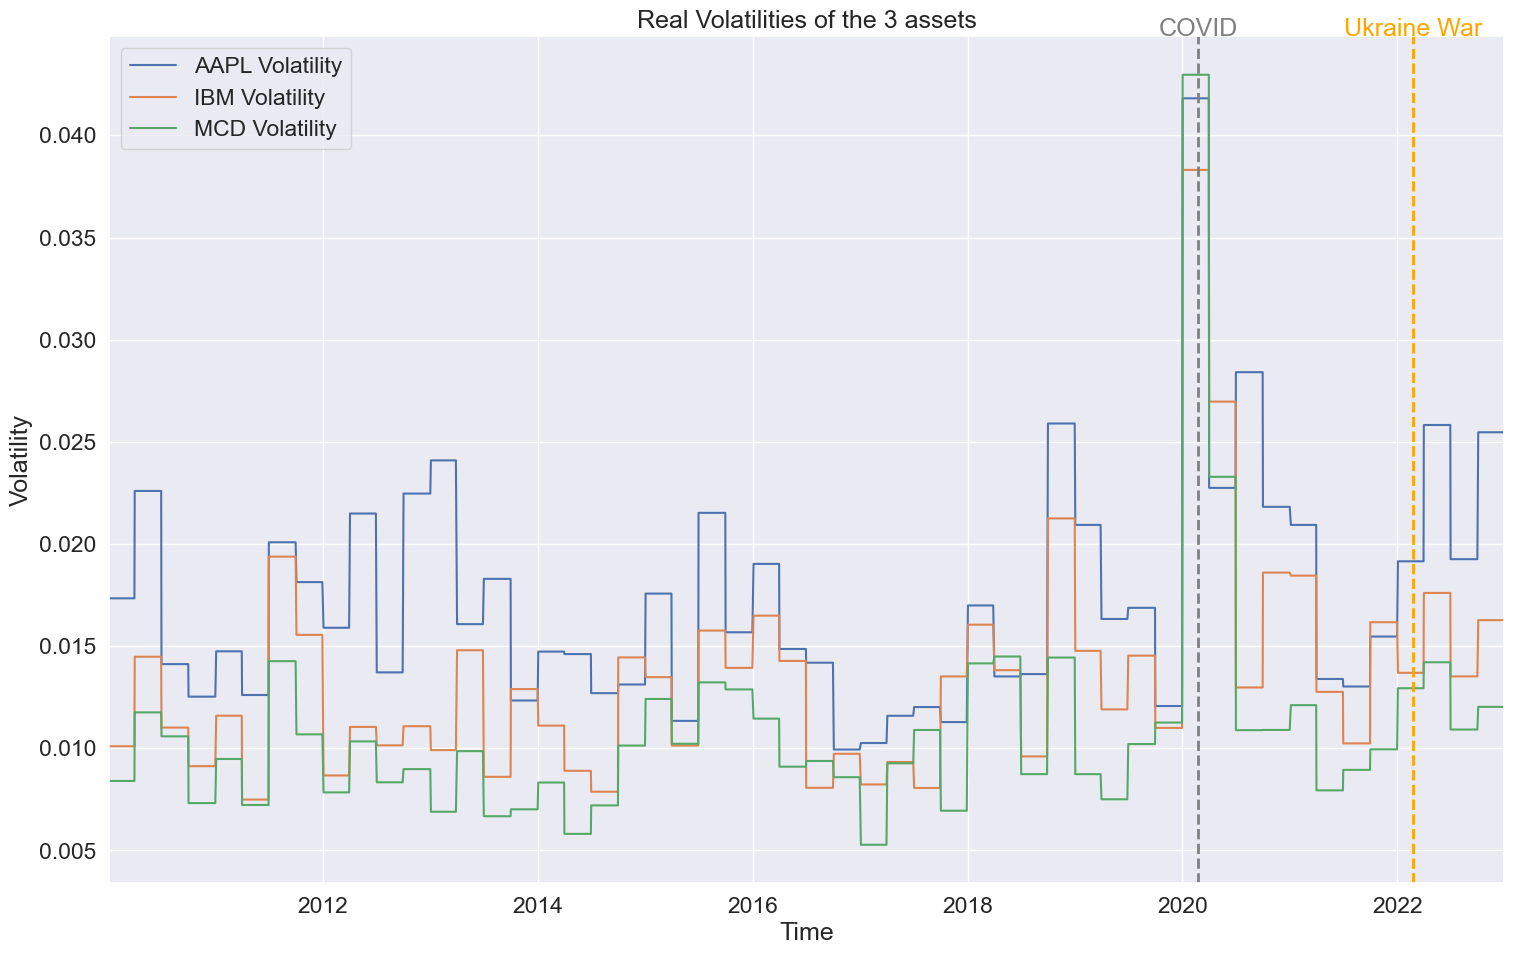

lenght of the real volatilities: 3272
lenght of the modified volatilities: 3272


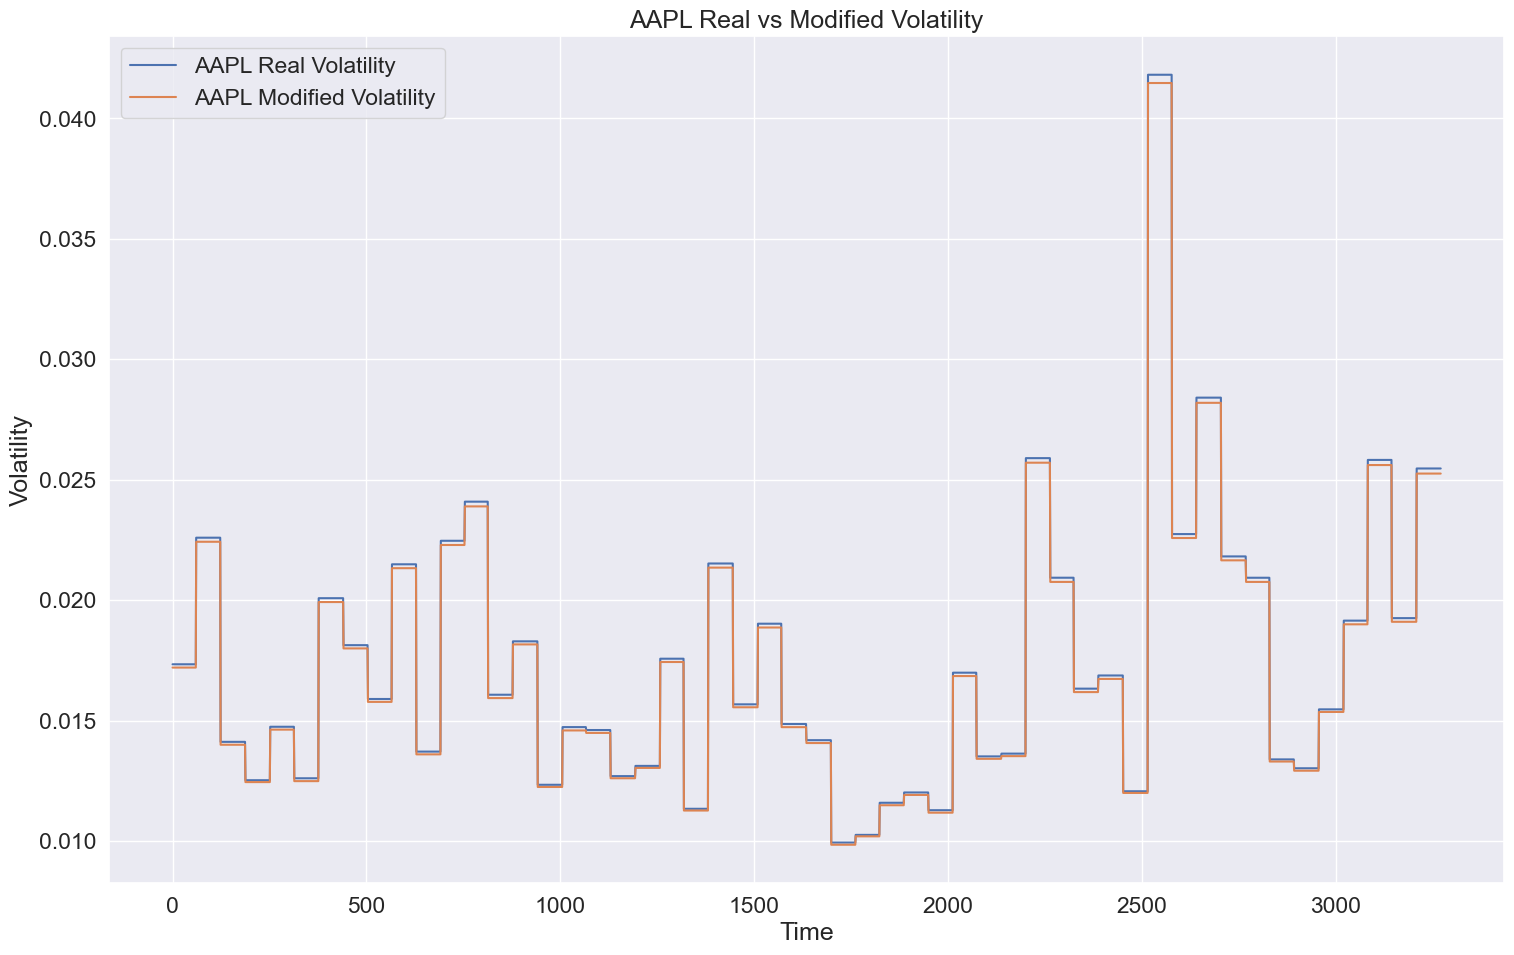

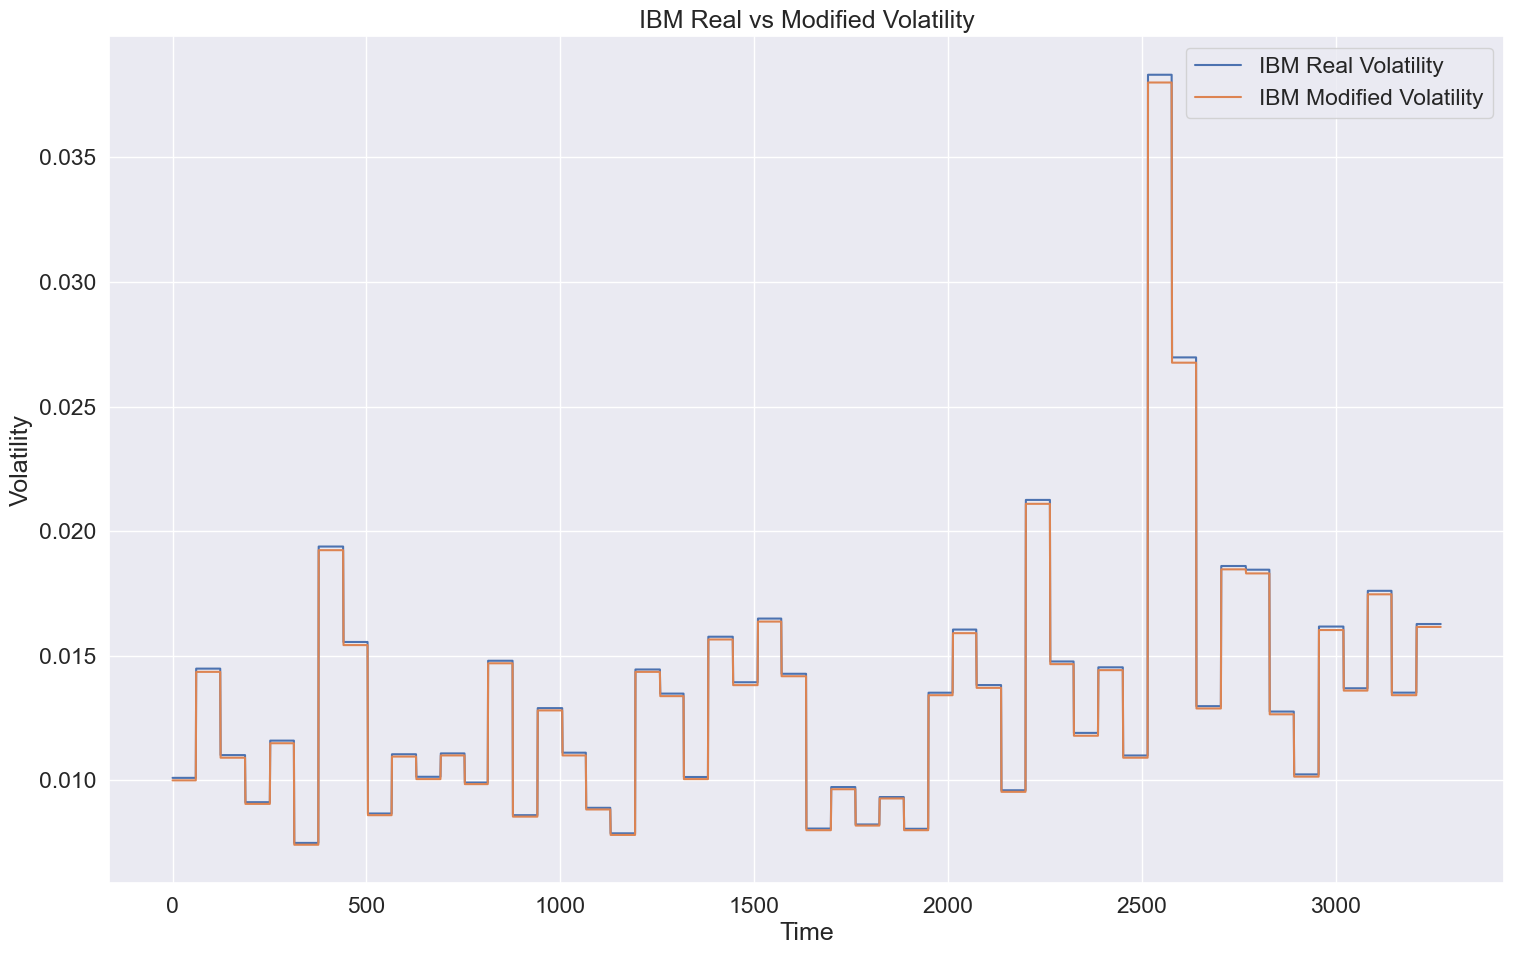

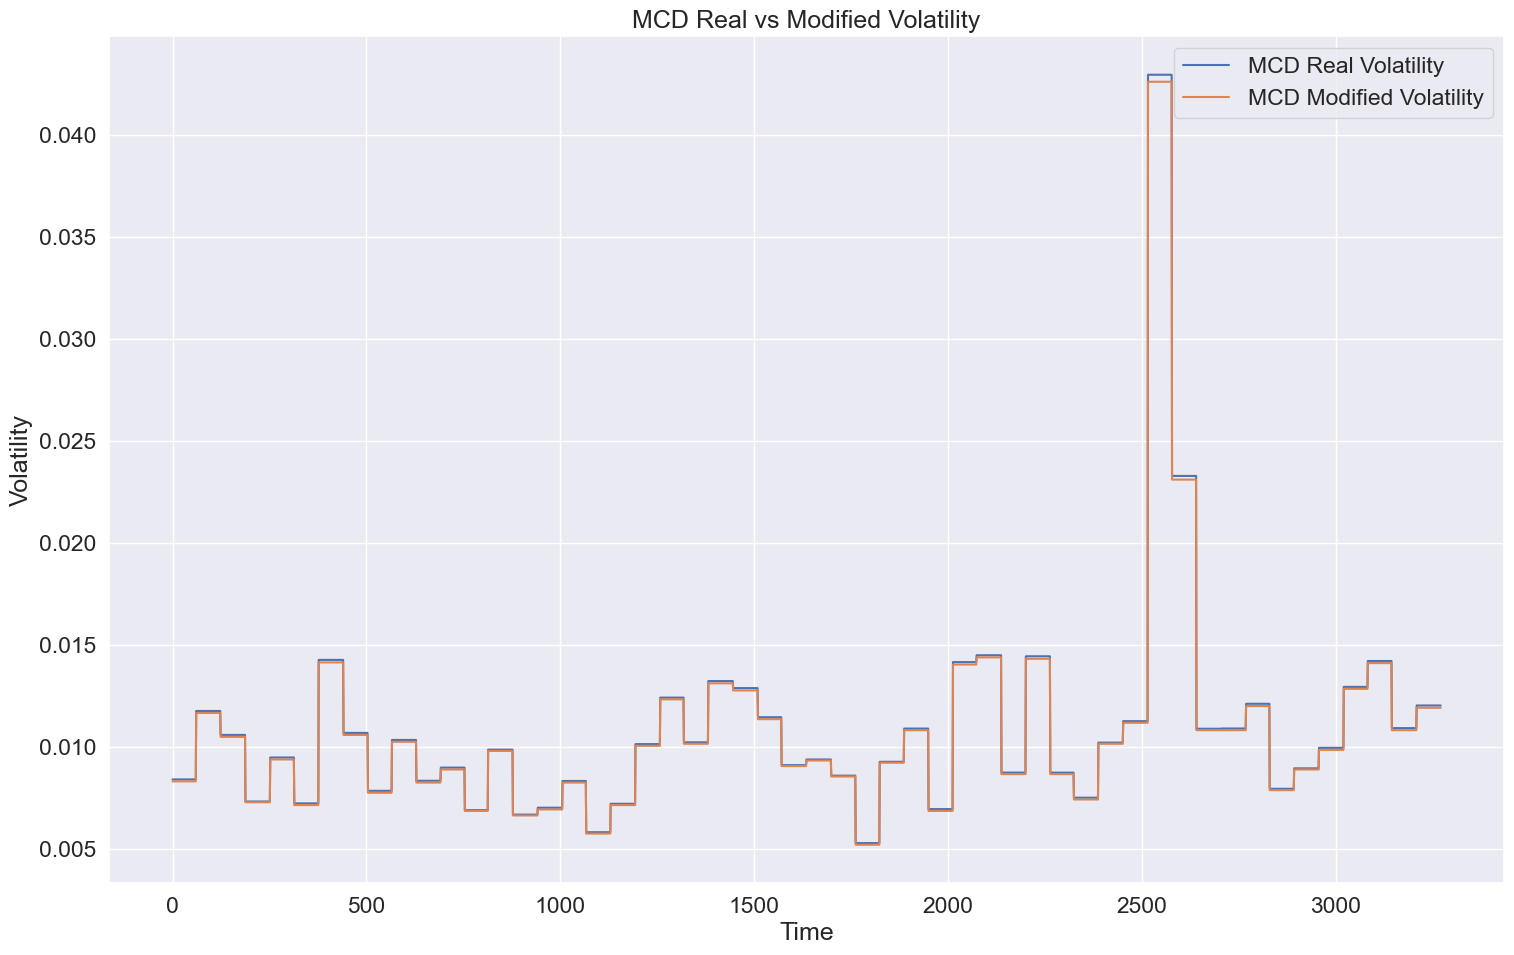

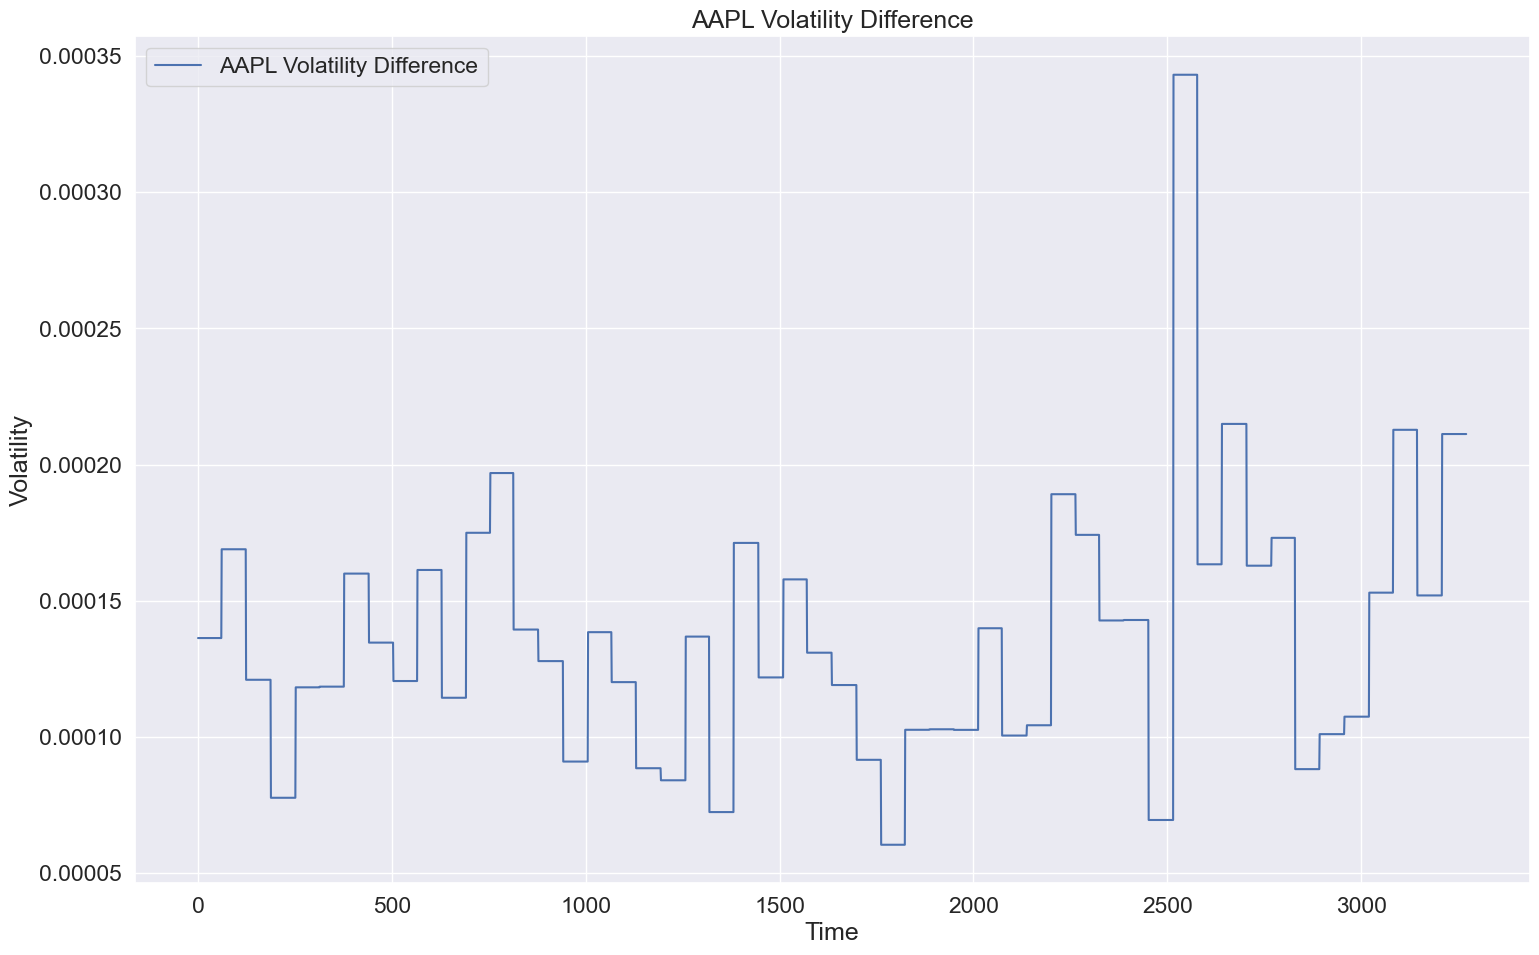

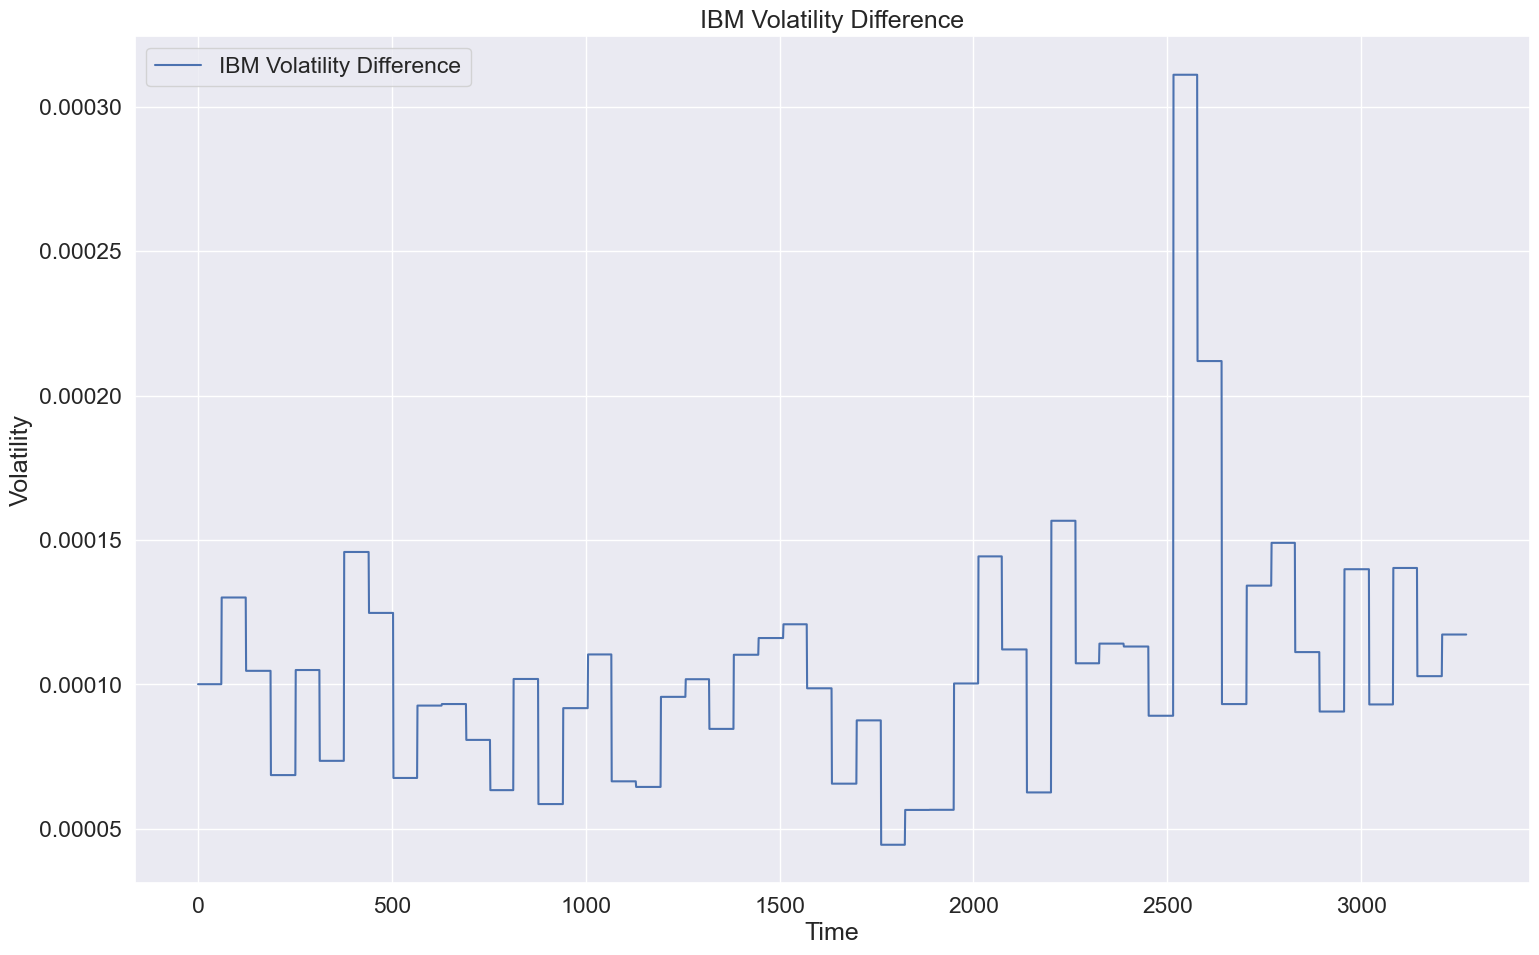

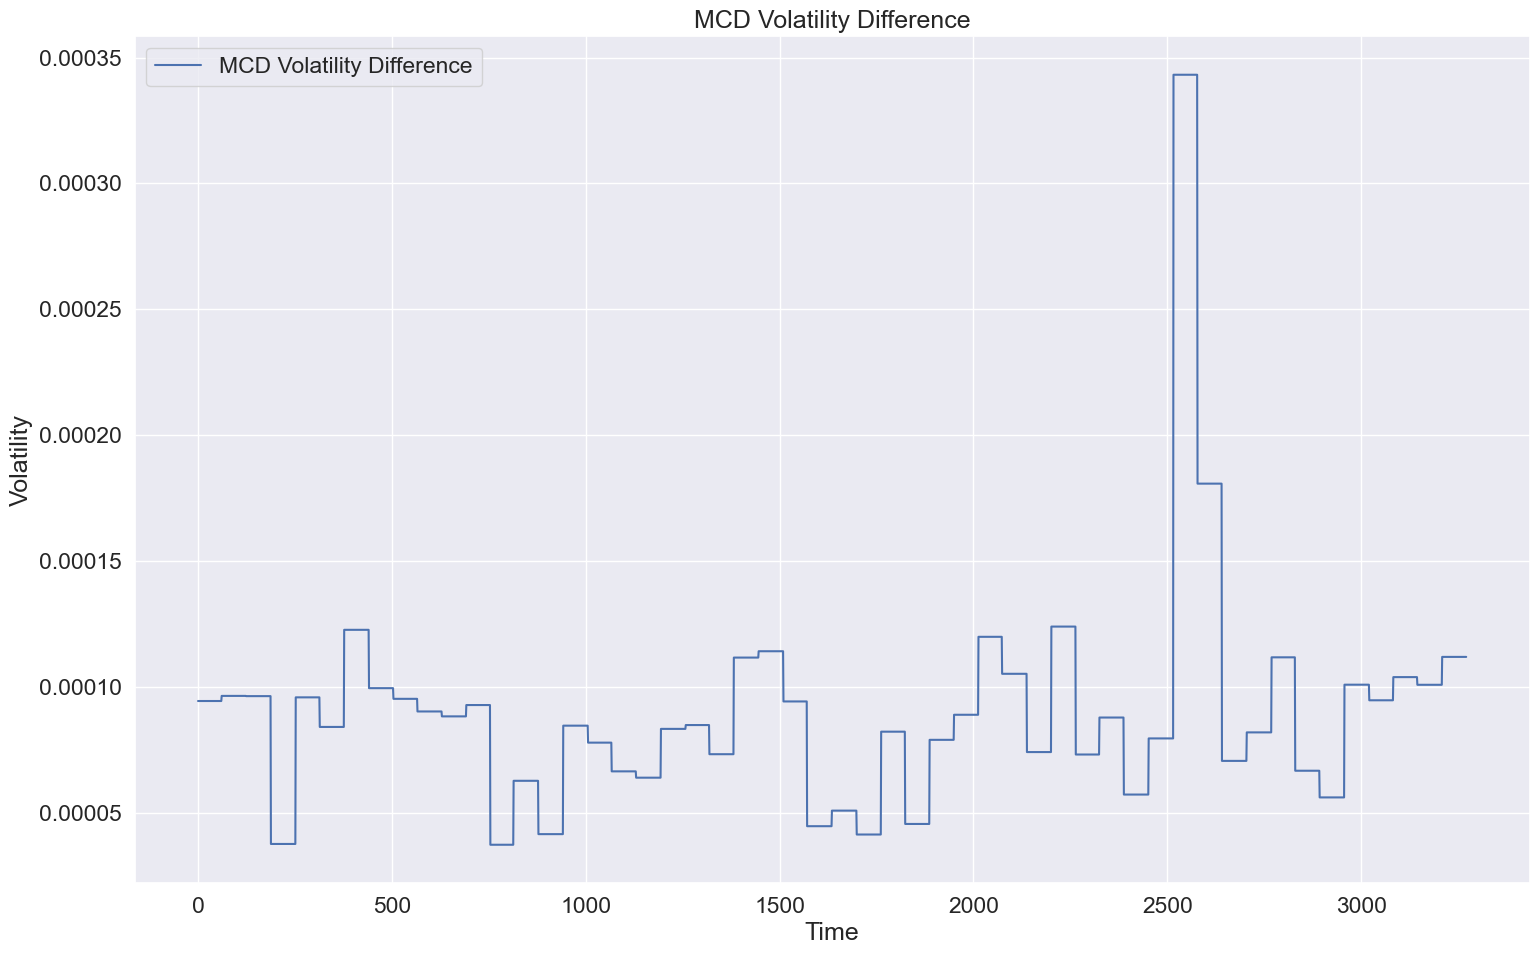

In [19]:
# THIS IS THE VISUALIZATION OF THE REAL VOLAITILITIES OF THE 3 ASSETS

# now calculates/extract the real volatilities of the 3 assets
real_volatilities_modified = {}

for date, cov_matrix in prescientDict.items():
    volatilities = np.sqrt(np.diag(cov_matrix.values))
    real_volatilities_modified[date] = pd.DataFrame(data = volatilities, index = cov_matrix.index, columns = ["volatility"])

# now real_volatilities_modified is a dictionary that contains the real volatilities of the 3 assets for every day with the same key of the prescientDict dictionary(the timestamp)

# now separate the real volatilities of the 3 assets in 3 different dataframes
volatility_dict_aapl = {}
volatility_dict_ibm = {}
volatility_dict_mcd = {}

for date, volatilities in real_volatilities_modified.items():
    volatility_dict_aapl[date] = volatilities.loc[7]["volatility"] # 7 is the PERMCO code of AAPL
    volatility_dict_ibm[date] = volatilities.loc[20990]["volatility"] # 20990 is the PERMCO code of IBM
    volatility_dict_mcd[date] = volatilities.loc[21177]["volatility"] # 21177 is the PERMCO code of MCD

# Convert the dictionaries to DataFrames for easier manipulation and plotting
df_volatility_aapl = pd.DataFrame(list(volatility_dict_aapl.items()), columns=['Date', 'AAPL Volatility'])
df_volatility_ibm = pd.DataFrame(list(volatility_dict_ibm.items()), columns=['Date', 'IBM Volatility'])
df_volatility_mcd = pd.DataFrame(list(volatility_dict_mcd.items()), columns=['Date', 'MCD Volatility'])

# Set the 'Date' column as the index
df_volatility_aapl.set_index('Date', inplace=True)
df_volatility_ibm.set_index('Date', inplace=True)
df_volatility_mcd.set_index('Date', inplace=True)

# Plot the real volatilities of the 3 assets
plt.figure(figsize=(18, 11))
plt.plot(df_volatility_aapl, label='AAPL Volatility')
plt.plot(df_volatility_ibm, label='IBM Volatility')
plt.plot(df_volatility_mcd, label='MCD Volatility')
plt.legend()
plt.title("Real Volatilities of the 3 assets")
plt.xlabel("Time")
plt.ylabel("Volatility")

# Adding vertical lines for specific events
plt.axvline(pd.Timestamp('2020-02-24'), color='gray', linestyle='--', lw=2)  # COVID start
plt.axvline(pd.Timestamp('2022-02-24'), color='orange', linestyle='--', lw=2)  # Ukraine War start

# Annotations for the events
plt.text(pd.Timestamp('2020-02-24'), plt.ylim()[1], 'COVID', horizontalalignment='center', color='gray')
plt.text(pd.Timestamp('2022-02-24'), plt.ylim()[1], 'Ukraine War', horizontalalignment='center', color='orange')

# Set x-axis limits to match the start and end dates
plt.xlim(left=df_volatility_aapl.index[0], right=df_volatility_aapl.index[-1])
plt.show()


##################################################################################
# now save every volatility value in a vector. This vector will contain only the value of the apple volatility, without timestamp
aapl_real_volatility = df_volatility_aapl["AAPL Volatility"].values
real_volatility_startDate = df_volatility_aapl.index[0]
real_volatility_endDate = df_volatility_aapl.index[-1]

ibm_real_volatility = df_volatility_ibm["IBM Volatility"].values
mcd_real_volatility = df_volatility_mcd["MCD Volatility"].values

# now do the same thing with the volatilities calculated using the empirical covariance matrix
aapl_modified_volatility = list(aaplModifiedVolatility.values())
ibm_modified_volatility = list(ibmModifiedVolatility.values())
mcd_modified_volatility = list(mcdModifiedVolatility.values())

print("lenght of the real volatilities: " + str(len(aapl_real_volatility)))
print("lenght of the modified volatilities: " + str(len(aapl_modified_volatility)))

# plot 3 charts to compare the real volatilities with the modified volatilities
plt.figure(figsize=(18, 11))
plt.plot(aapl_real_volatility, label='AAPL Real Volatility')
plt.plot(aapl_modified_volatility, label='AAPL Modified Volatility')
plt.legend()
plt.title("AAPL Real vs Modified Volatility")
plt.xlabel("Time")
plt.ylabel("Volatility")

plt.figure(figsize=(18, 11))
plt.plot(ibm_real_volatility, label='IBM Real Volatility')
plt.plot(ibm_modified_volatility, label='IBM Modified Volatility')
plt.legend()
plt.title("IBM Real vs Modified Volatility")
plt.xlabel("Time")
plt.ylabel("Volatility")

plt.figure(figsize=(18, 11))
plt.plot(mcd_real_volatility, label='MCD Real Volatility')
plt.plot(mcd_modified_volatility, label='MCD Modified Volatility')
plt.legend()
plt.title("MCD Real vs Modified Volatility")
plt.xlabel("Time")
plt.ylabel("Volatility")

plt.show()

# now do the difference between the real and modified volatilities
aapl_volatility_difference = aapl_real_volatility - aapl_modified_volatility
ibm_volatility_difference = ibm_real_volatility - ibm_modified_volatility
mcd_volatility_difference = mcd_real_volatility - mcd_modified_volatility

# plot the difference between the real and modified volatilities
plt.figure(figsize=(18, 11))
plt.plot(aapl_volatility_difference, label='AAPL Volatility Difference')
plt.legend()
plt.title("AAPL Volatility Difference")
plt.xlabel("Time")
plt.ylabel("Volatility")

plt.figure(figsize=(18, 11))
plt.plot(ibm_volatility_difference, label='IBM Volatility Difference')
plt.legend()
plt.title("IBM Volatility Difference")
plt.xlabel("Time")
plt.ylabel("Volatility")

plt.figure(figsize=(18, 11))
plt.plot(mcd_volatility_difference, label='MCD Volatility Difference')
plt.legend()
plt.title("MCD Volatility Difference")
plt.xlabel("Time")
plt.ylabel("Volatility")

plt.show()
##################################################################################